# **Conway's Game of Life**
Le jeu de la vie de Conway est un automate cellulaire (écrire le résumé et nos objectifs)

# **Librairie**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from PIL import Image
from IPython.display import display, clear_output
import time

# **Implémentation du jeu de la vie**

**Rules of Conway's Game of Life**
*   Si une cellule a exactement trois voisines vivantes, elle est vivante à l’étape suivante.
*   Si une cellule a exactement deux voisines vivantes, elle reste dans son état actuel à l’étape suivante.
*   Si une cellule a strictement moins de deux ou strictement plus de trois voisines vivantes, elle est morte à l’étape suivante.

**game implementation parameters :**

In [119]:
GRID_SIZE = 100
EPOCH = 100
INTERVAL = 200

In [3]:
def random_grid(size):
  return np.random.randint(0, 2, size=(size, size))

In [4]:
def count_neighbours(grid):
  # On définit un noyau (filtre) :
  # 1 partout (pour compter le voisin)
  # 0 au centre (on ne se compte pas soi-même)
  kernel = np.array([[1, 1, 1],
                      [1, 0, 1],
                      [1, 1, 1]])

  return convolve2d(grid, kernel, mode='same', boundary='fill', fillvalue=0)

In [5]:
def next_state(grid):
  next_grid = np.zeros(grid.shape, dtype=int)
  neighbours = count_neighbours(grid)
  next_grid[neighbours == 3] = 1
  next_grid[neighbours == 2] = grid[neighbours == 2]
  return next_grid

In [6]:
def plot_grid(grid, epoch=0):
  plt.imshow(grid, cmap='binary')
  plt.title(f"Jeu de la Vie - Époque {epoch}", fontsize=16)
  plt.show()

In [7]:
def simulate(grid, epoch, white_bg=False):
  print("Jeu de la vie - Simulation en cours ...")
  text_handle = None
  display_handle = None

  for i in range(epoch) :
    if white_bg:
      img_array = ((1 - grid) * 255).astype('uint8')
    else :
      img_array = (grid * 255).astype('uint8')

    img = Image.fromarray(img_array)
    img = img.convert('L')
    img = img.resize((400, 400), Image.NEAREST)

    label = f"Génération : {i + 1} / {epoch}"

    # Afficher ou mettre à jour
    if i == 0:
      text_handle = display(label, display_id=True)
      display_handle = display(img, display_id=True)
    else:
      text_handle.update(label)
      display_handle.update(img)

    grid = next_state(grid)
    time.sleep(INTERVAL / 1000)
  print("Simulation terminée!")

Jeu de la vie - Simulation en cours ...


'Génération : 100 / 100'

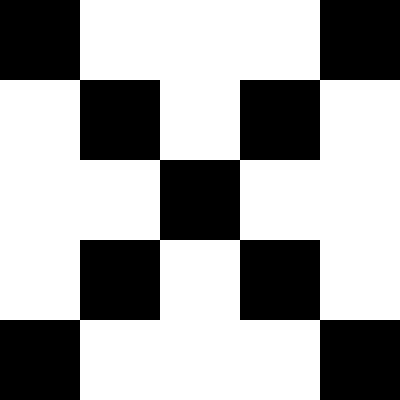

Simulation terminée!


In [8]:
grid = random_grid(GRID_SIZE)
simulate(grid, EPOCH)

# **Génération d'un dataset**

**dataset parameters :**

In [9]:
TRAINING_SIZE = 3000
TEST_SIZE = 1000
VAL_SIZE = 1000

**dataset hyperparameters**

In [10]:
batch_size = 64

**génération des données d'entrainement, test et validation :**

In [120]:
def generate_data(grid_size, data_size) :
  data = []
  label = []

  for i in range(data_size):
    input_grid = random_grid(grid_size)
    data.append(input_grid)
    label_grid = next_state(input_grid)
    label.append(label_grid)

  df = pd.DataFrame({
      'data' : data,
      'label' : label
  })

  return df

In [121]:
train_df = generate_data(GRID_SIZE, TRAINING_SIZE)
test_df = generate_data(GRID_SIZE, TEST_SIZE)
val_df = generate_data(GRID_SIZE, VAL_SIZE)

**implémentation d'un dataset**

In [13]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [14]:
class gol_dataset(Dataset) :
  def __init__(self, data, label):
    self.data = data
    self.label = label

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    x = torch.tensor(self.data[index], dtype=torch.float32)
    y = torch.tensor(self.label[index], dtype=torch.float32)
    x = x.unsqueeze(0)
    y = y.unsqueeze(0)
    return x, y

In [122]:
train_dataset = gol_dataset(train_df['data'], train_df['label'])
test_dataset = gol_dataset(test_df['data'], test_df['label'])
val_dataset = gol_dataset(val_df['data'], val_df['label'])

In [123]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True)

In [124]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"train shape : {train_features[0].shape}")
print(f"label shape : {train_labels[0].shape}")

Feature batch shape: torch.Size([64, 1, 100, 100])
Labels batch shape: torch.Size([64, 1, 100, 100])
train shape : torch.Size([1, 100, 100])
label shape : torch.Size([1, 100, 100])


# **Implémentation d'un réseau de neuronne**

In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

**hyperpameters :**

In [126]:
lr = 0.001
momentum = 0.9
epochs = 100

**Define a CNN**

In [25]:
class GOL_CNN(nn.Module):
  def __init__(self):
    super().__init__()

    # --- Étape 1 : Ouverture (1 -> 32 canaux) ---
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(32) # Toujours après une conv

    # --- Étape 2, 3, 4 : Le Corps (32 -> 32 canaux) ---
    self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
    self.bn3   = nn.BatchNorm2d(32)

    self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
    self.bn4   = nn.BatchNorm2d(32)

    # --- Étape 5 : Fermeture / Tête (32 -> 1 canal) ---
    self.head = nn.Conv2d(32, 1, kernel_size=1)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))

    x = self.head(x)

    return x

In [127]:
gol_cnn = GOL_CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gol_cnn.to(device)

GOL_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
)

**Define a Loss function and an optimizer**

In [128]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(gol_cnn.parameters(), lr=lr, momentum=momentum)

**Train the network :**

In [129]:
train_losses = []
test_losses = []
test_accuracies = []

loop = tqdm(range(epochs), desc="Training")

for epoch in loop:
  gol_cnn.train()
  running_train_loss = 0.0

  for inputs, labels in train_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = gol_cnn(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_train_loss += loss.item()

  # Calcul de la perte moyenne pour cette époque
  avg_train_loss = running_train_loss / len(train_dataloader)
  train_losses.append(avg_train_loss)

  # --- PHASE DE TEST / VALIDATION ---
  gol_cnn.eval()  # Active le mode évaluation
  running_test_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, labels in test_dataloader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = gol_cnn(inputs)
      predicted = (outputs.data > 0.5).float()
      loss = criterion(predicted, labels)
      running_test_loss += loss.item()

      total += labels.numel() # Nombre total de cellules (pixels)
      correct += (predicted == labels).sum().item()

  avg_test_loss = running_test_loss / len(test_dataloader)
  accuracy = 100 * correct / total

  test_losses.append(avg_test_loss)
  test_accuracies.append(accuracy)

  # Mise à jour de la barre tqdm
  loop.set_postfix(loss_train=f"{avg_train_loss:.4f}", loss_test=f"{avg_test_loss:.4f}", acc=f"{accuracy:.2f}%")

print('Finished Training')

Training: 100%|██████████| 100/100 [06:38<00:00,  3.98s/it, acc=99.99%, loss_test=0.5863, loss_train=0.0057]

Finished Training


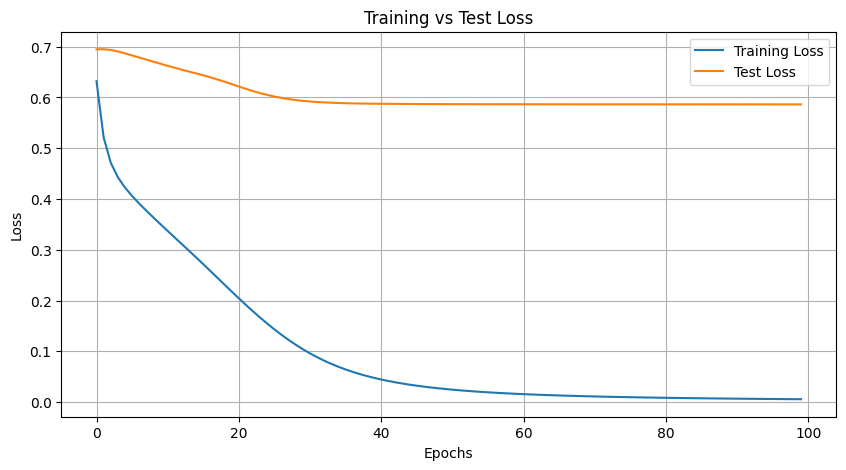

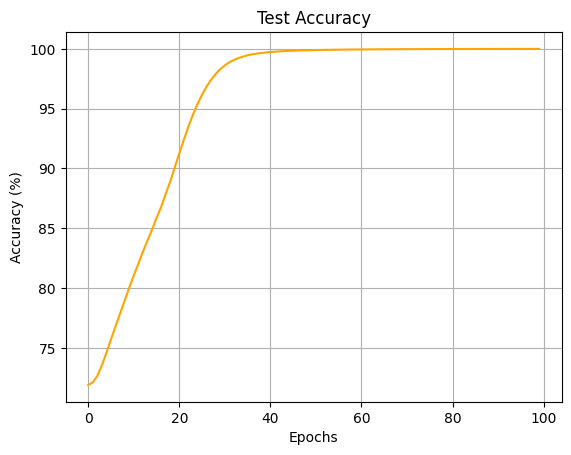

In [130]:
# --- GRAPHIQUE DES PERTES ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

# **Visualisation**

In [54]:
def grid_accuracy(outputs, targets) :
  predicted = (outputs > 0.5).float()
  total = predicted.numel()
  correct = (predicted.cpu() == targets).float().sum()
  return (correct / total).item()

accuracy :  1.0
prediction


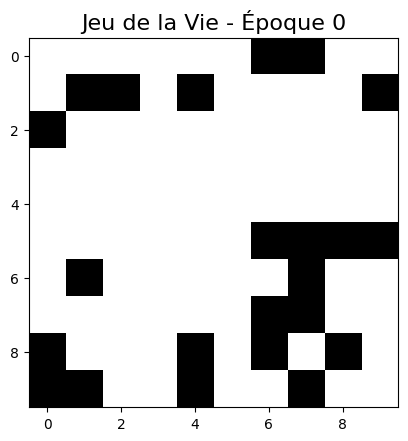

output


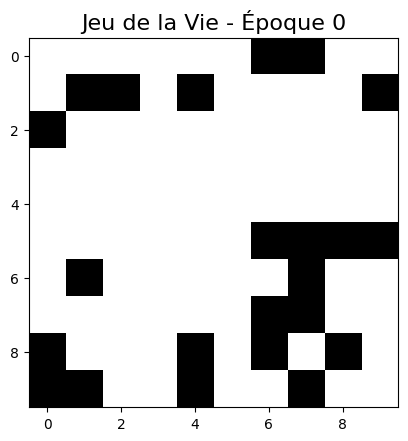

In [104]:
r_grid = random_grid(10)
n_grid = next_state(r_grid)
r_grid = torch.tensor(r_grid, dtype=torch.float32)
r_grid = r_grid.unsqueeze(0)
r_grid = r_grid.unsqueeze(0)
r_grid = r_grid.to(device)

with torch.no_grad():
  outputs = gol_cnn(r_grid)

print("accuracy : ", grid_accuracy(outputs, n_grid))
predicted = (outputs.data > 0.5).float()
print("prediction")
plot_grid(predicted.squeeze(0).squeeze(0).cpu())
print("output")
plot_grid(n_grid)

In [113]:
def simulate_and_predict(model, grid_size=10, epochs=20, white_bg=False):
    """
    Simule le jeu de la vie et prédit l'état après N époques
    Affiche la simulation à gauche
    """
    print("=== Simulation et Prédiction ===")
    print(f"Grille initiale : {grid_size}x{grid_size}")
    print(f"Nombre d'époques : {epochs}\n")

    # Génération de la grille initiale
    initial_grid = random_grid(grid_size)
    current_grid = initial_grid.copy()

    # Prédiction avec le modèle
    print("\nCalcul de la prédiction avec le modèle...")
    grid_tensor = torch.tensor(initial_grid, dtype=torch.float32)
    grid_tensor = grid_tensor.unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_grid = grid_tensor
        for _ in range(epochs):
            pred_grid = model(pred_grid)
            pred_grid = (pred_grid > 0.5).float()

    predicted_final = pred_grid.squeeze(0).squeeze(0).cpu().numpy()
    if white_bg:
      img_pred = ((1 - predicted_final) * 255).astype('uint8')
    else:
      img_pred = (predicted_final * 255).astype('uint8')
    img_pred = Image.fromarray(img_pred)
    img_pred = img_pred.convert('L')
    img_pred = img_pred.resize((400, 400), Image.NEAREST)

    # Simulation visuelle
    print("Simulation du jeu de la vie...")
    text_handle = None
    display_handle = None
    text_handle_pred = None
    display_handle_pred = None

    for i in range(epochs + 1):
        if white_bg:
            img_array = ((1 - current_grid) * 255).astype('uint8')
        else:
            img_array = (current_grid * 255).astype('uint8')

        img = Image.fromarray(img_array)
        img = img.convert('L')
        img = img.resize((400, 400), Image.NEAREST)

        # création d'une image combinée :
        combined_width = 840
        combined_height = 400
        combined_img = Image.new('RGB', (combined_width, combined_height), color='white')

        img_real_rgb = img.convert('RGB')
        img_pred_rgb = img_pred.convert('RGB')

        combined_img.paste(img_real_rgb, (0, 0))
        combined_img.paste(img_pred_rgb, (420, 0))

        label_gen = f"Génération : {i} / {epochs}"
        label_pred = f"Prédiction de la génération {epochs}"

        if i == 0:
            text_handle = display(label_gen, display_id=True)
            display_handle = display(combined_img, display_id=True)
            text_handle_pred = display(label_pred, display_id=True)
        else:
            text_handle.update(label_gen)
            display_handle.update(combined_img)
            text_handle_pred.update(label_pred)

        if i < epochs:
          current_grid = next_state(current_grid)
          time.sleep(INTERVAL / 1000)

    # État final réel
    final_grid_real = current_grid

    # Calcul de l'accuracy
    accuracy = grid_accuracy(
        torch.tensor(predicted_final).unsqueeze(0).unsqueeze(0),
        final_grid_real
    )

    print(f"\nSimulation terminée!")
    print(f"Accuracy de la prédiction : {accuracy * 100:.2f}%")

    return initial_grid, final_grid_real, predicted_final, accuracy

=== Simulation et Prédiction ===
Grille initiale : 10x10
Nombre d'époques : 1


Calcul de la prédiction avec le modèle...
Simulation du jeu de la vie...


'Génération : 1 / 1'

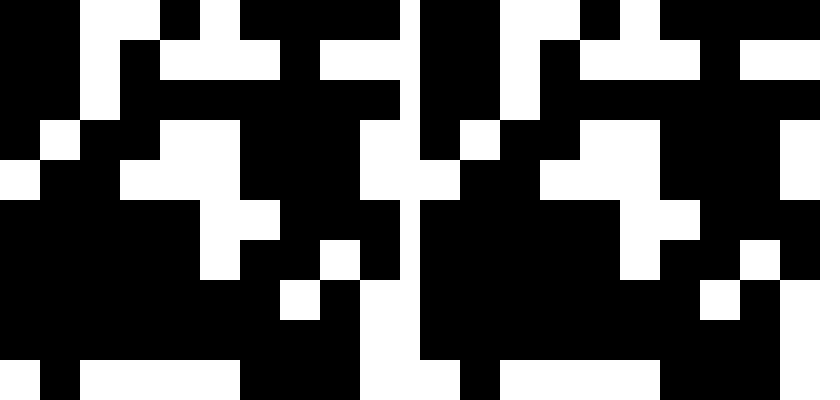

'Prédiction de la génération 1'


Simulation terminée!
Accuracy de la prédiction : 100.00%


In [141]:
# Exécution
initial, real_final, pred_final, acc = simulate_and_predict(
    model=gol_cnn,
    grid_size=10,
    epochs=1,
    white_bg=False
)

# **References**



*   [Recommending Training Set Sizes for Classification](https://arxiv.org/pdf/2102.09382)

